In [1]:
import sys
import os

# Get current working directory
current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)
print(parent_dir)

#Insert the path to the parent directory
sys.path.insert(0, parent_dir)

c:\Users\Yayerad\Telecom\notebooks
c:\Users\Yayerad\Telecom


In [2]:
# Import the custom loader script
from scripts.db_loader import load_data

In [3]:
# Load data from the database into a DataFrame
df = load_data()

# Check if data is loaded
if df is not None:
    print("Data loaded successfully.")
    print(df.head())  # Display the first few rows of the data

Data loaded successfully.
   MSISDN/Number  TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  \
0   3.366496e+10                          NaN                          NaN   
1   3.368185e+10                          NaN                          NaN   
2   3.376063e+10                          NaN                          NaN   
3   3.375034e+10                          NaN                          NaN   
4   3.369980e+10                          NaN                          NaN   

   Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0             42.0              5.0                     23.0   
1             65.0              5.0                     16.0   
2              NaN              NaN                      6.0   
3              NaN              NaN                     44.0   
4              NaN              NaN                      6.0   

   Avg Bearer TP UL (kbps)                 Handset Type  
0                     44.0   Samsung Galaxy A5 Sm-A520F  
1   

Data Aggregation and Cleaning

In [19]:
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import zscore

# Fill missing values for numerical columns with their mean
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill missing values for categorical columns with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Proceed with further analysis
# Example: Aggregate data per customer (MSISDN)
user_experience = df.groupby(["MSISDN/Number", "Handset Type"]).agg({
    "TCP DL Retrans. Vol (Bytes)": "sum",
    "TCP UL Retrans. Vol (Bytes)": "sum",
    "Avg RTT DL (ms)": "mean",
    "Avg RTT UL (ms)": "mean",
    "Avg Bearer TP DL (kbps)": "mean",
    "Avg Bearer TP UL (kbps)": "mean"
}).reset_index()



# Calculate the aggregated metrics
user_experience['Avg TCP Retransmission'] = (user_experience['TCP DL Retrans. Vol (Bytes)'] + user_experience['TCP UL Retrans. Vol (Bytes)']) / 2
user_experience['Avg RTT'] = (user_experience['Avg RTT DL (ms)'] + user_experience['Avg RTT UL (ms)']) / 2
user_experience['Avg Throughput'] = (user_experience['Avg Bearer TP DL (kbps)'] + user_experience['Avg Bearer TP UL (kbps)']) / 2

# Handling outliers using z-score
user_experience['Avg TCP Retransmission'] = user_experience['Avg TCP Retransmission'].apply(lambda x: x if abs(zscore([x])) < 3 else user_experience['Avg TCP Retransmission'].mean())
user_experience['Avg RTT'] = user_experience['Avg RTT'].apply(lambda x: x if abs(zscore([x])) < 3 else user_experience['Avg RTT'].mean())
user_experience['Avg Throughput'] = user_experience['Avg Throughput'].apply(lambda x: x if abs(zscore([x])) < 3 else user_experience['Avg Throughput'].mean())

C:\Users\Yayerad\AppData\Local\Temp\ipykernel_17972\4222928736.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [20]:
# Print the first few rows of the processed DataFrame
print("Processed DataFrame:")
print(user_experience.head())

Processed DataFrame:
   MSISDN/Number                    Handset Type  TCP DL Retrans. Vol (Bytes)  \
0   3.360100e+10  Huawei P20 Lite Huawei Nova 3E                 2.080991e+07   
1   3.360100e+10          Apple iPhone 7 (A1778)                 2.080991e+07   
2   3.360100e+10                       undefined                 2.080991e+07   
3   3.360101e+10         Apple iPhone 5S (A1457)                 1.066000e+03   
4   3.360101e+10         Apple iPhone Se (A1723)                 3.015954e+07   

   TCP UL Retrans. Vol (Bytes)  Avg RTT DL (ms)  Avg RTT UL (ms)  \
0                759658.664811        46.000000         0.000000   
1                759658.664811        30.000000         1.000000   
2                759658.664811       109.795706        17.662883   
3                759658.664811        69.000000        15.000000   
4                780860.664811        57.000000         2.500000   

   Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  Avg TCP Retransmission  \
0   

Compute and List Top, Bottom, and Most Frequent Values

In [21]:
# Top 10 values
top_tcp = user_experience.nlargest(10, 'Avg TCP Retransmission')
top_rtt = user_experience.nlargest(10, 'Avg RTT')
top_throughput = user_experience.nlargest(10, 'Avg Throughput')

print("Top 10 Avg TCP Retransmission:")
print(top_tcp)
print("\nTop 10 Avg RTT:")
print(top_rtt)
print("\nTop 10 Avg Throughput:")
print(top_throughput)

Top 10 Avg TCP Retransmission:
   MSISDN/Number                                      Handset Type  \
0   3.360100e+10                    Huawei P20 Lite Huawei Nova 3E   
1   3.360100e+10                            Apple iPhone 7 (A1778)   
2   3.360100e+10                                         undefined   
3   3.360101e+10                           Apple iPhone 5S (A1457)   
4   3.360101e+10                           Apple iPhone Se (A1723)   
5   3.360101e+10                          Samsung Galaxy A8 (2018)   
6   3.360101e+10  Huawei Mate 10 Pro Porsche Design Huawei Mate 10   
7   3.360101e+10                 Samsung Galaxy S8 Plus (Sm-G955F)   
8   3.360101e+10                                         undefined   
9   3.360102e+10                            Apple iPhone X (A1865)   

   TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  Avg RTT DL (ms)  \
0                 2.080991e+07                 7.596587e+05        46.000000   
1                 2.080991e+07        

In [22]:
# Bottom 10 values
bottom_tcp = user_experience.nsmallest(10, 'Avg TCP Retransmission')
bottom_rtt = user_experience.nsmallest(10, 'Avg RTT')
bottom_throughput = user_experience.nsmallest(10, 'Avg Throughput')

print("\nBottom 10 by Avg TCP Retransmission:")
print(bottom_tcp)

print("\nBottom 10 by Avg RTT:")
print(bottom_rtt)

print("\nBottom 10 by Avg Throughput:")
print(bottom_throughput)


Bottom 10 by Avg TCP Retransmission:
   MSISDN/Number                                      Handset Type  \
0   3.360100e+10                    Huawei P20 Lite Huawei Nova 3E   
1   3.360100e+10                            Apple iPhone 7 (A1778)   
2   3.360100e+10                                         undefined   
3   3.360101e+10                           Apple iPhone 5S (A1457)   
4   3.360101e+10                           Apple iPhone Se (A1723)   
5   3.360101e+10                          Samsung Galaxy A8 (2018)   
6   3.360101e+10  Huawei Mate 10 Pro Porsche Design Huawei Mate 10   
7   3.360101e+10                 Samsung Galaxy S8 Plus (Sm-G955F)   
8   3.360101e+10                                         undefined   
9   3.360102e+10                            Apple iPhone X (A1865)   

   TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  Avg RTT DL (ms)  \
0                 2.080991e+07                 7.596587e+05        46.000000   
1                 2.080991e+07 

In [23]:
# Most frequent values
most_freq_tcp = user_experience['Avg TCP Retransmission'].mode()
most_freq_rtt = user_experience['Avg RTT'].mode()
most_freq_throughput = user_experience['Avg Throughput'].mode()

print("\nMost Frequent Avg TCP Retransmission:")
print(most_freq_tcp)
print("\nMost Frequent Avg RTT:")
print(most_freq_rtt)
print("\nMost Frequent Avg Throughput:")
print(most_freq_throughput)


Most Frequent Avg TCP Retransmission:
0    1.512405e+07
Name: Avg TCP Retransmission, dtype: float64

Most Frequent Avg RTT:
0    67.357564
Name: Avg RTT, dtype: float64

Most Frequent Avg Throughput:
0    6580.928911
Name: Avg Throughput, dtype: float64


Distribution Analysis

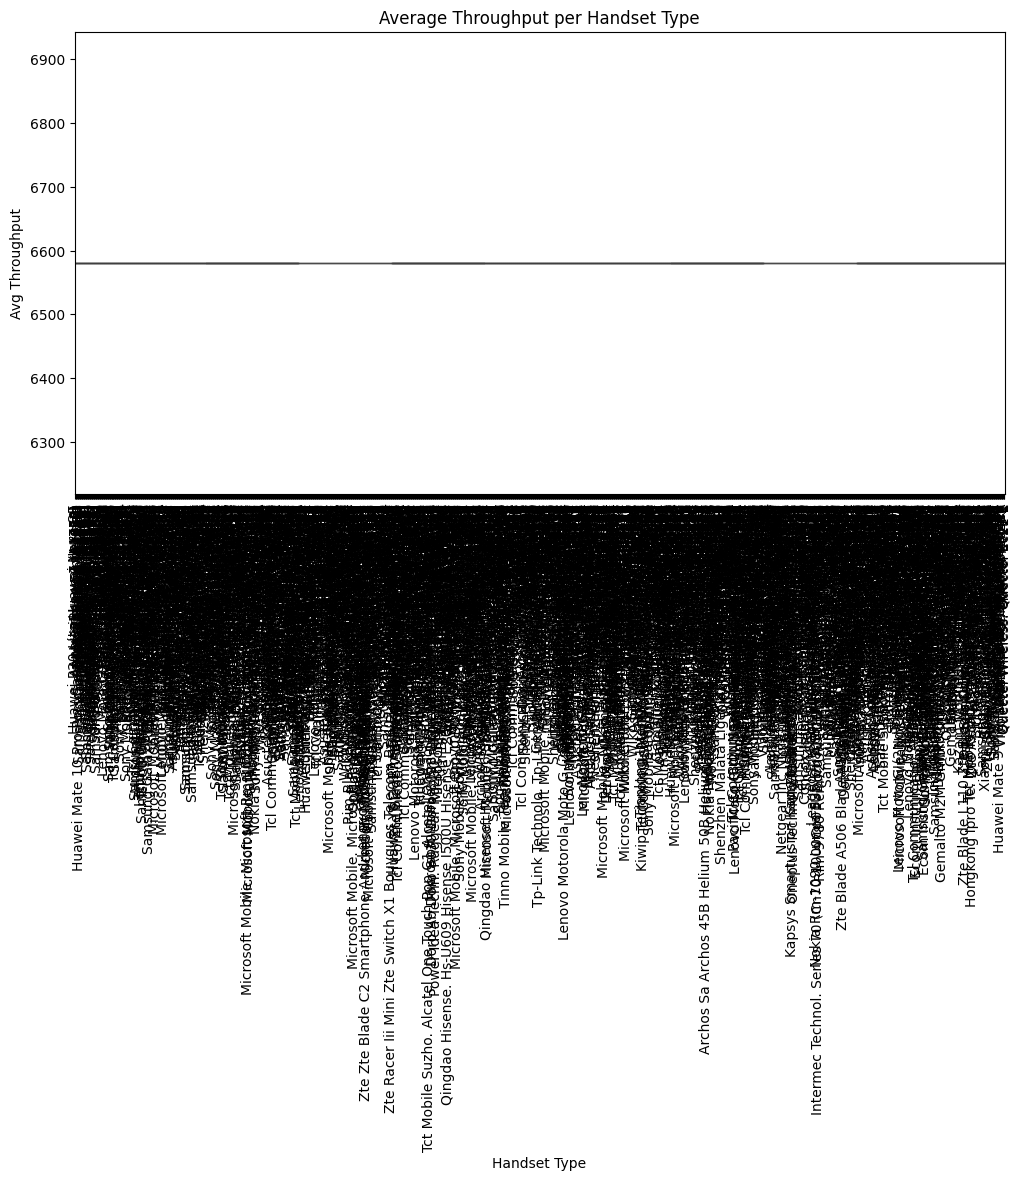

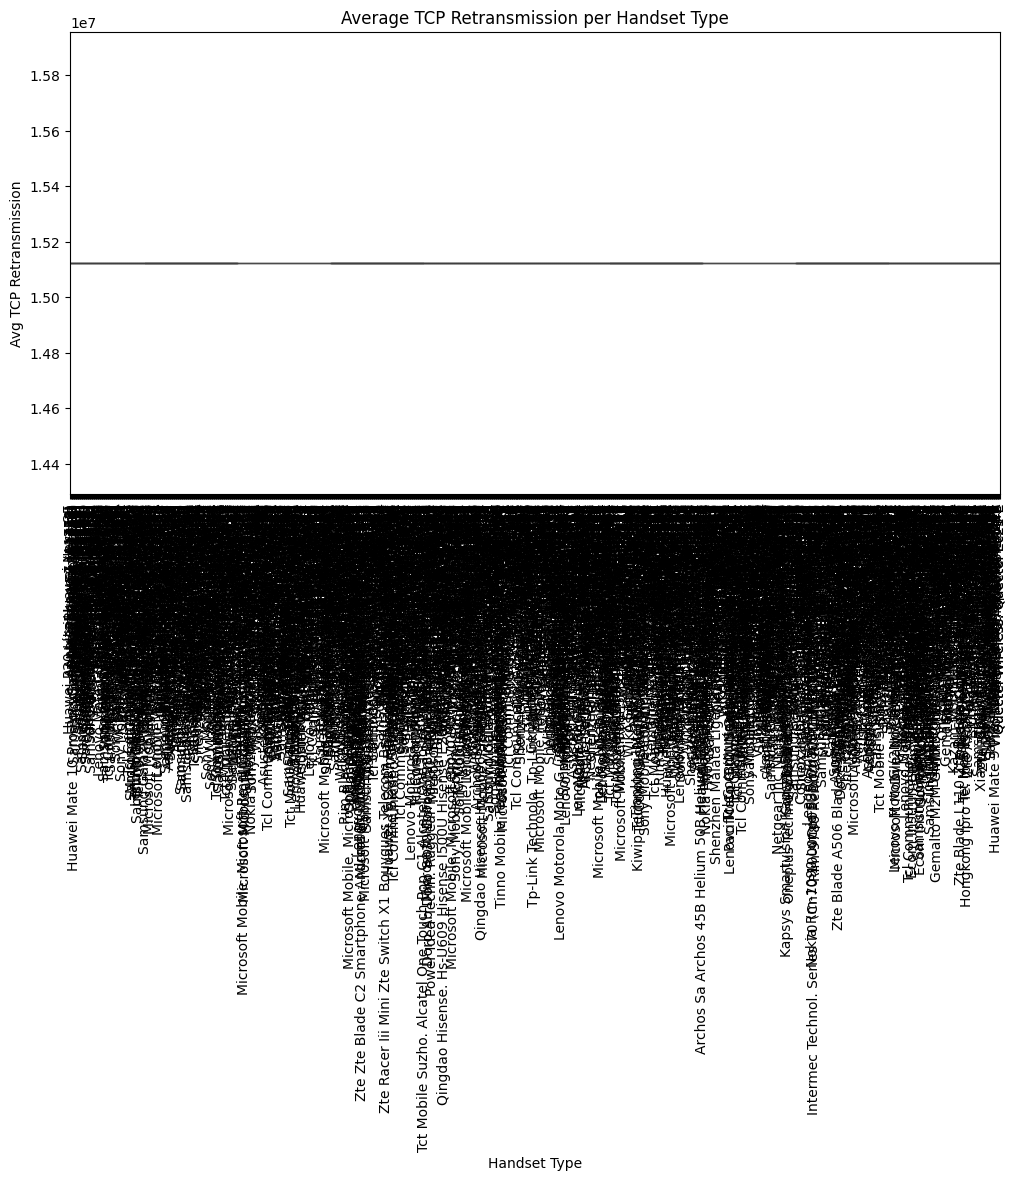

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of average throughput per handset type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Handset Type', y='Avg Throughput', data=user_experience)
plt.xticks(rotation=90)
plt.title('Average Throughput per Handset Type')
plt.show()

# Average TCP retransmission per handset type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Handset Type', y='Avg TCP Retransmission', data=user_experience)
plt.xticks(rotation=90)
plt.title('Average TCP Retransmission per Handset Type')
plt.show()


User Experience Clustering